# **Finding Lane Lines on the Road** 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [39]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
%matplotlib inline

## Compute the camera calibration using chessboard images


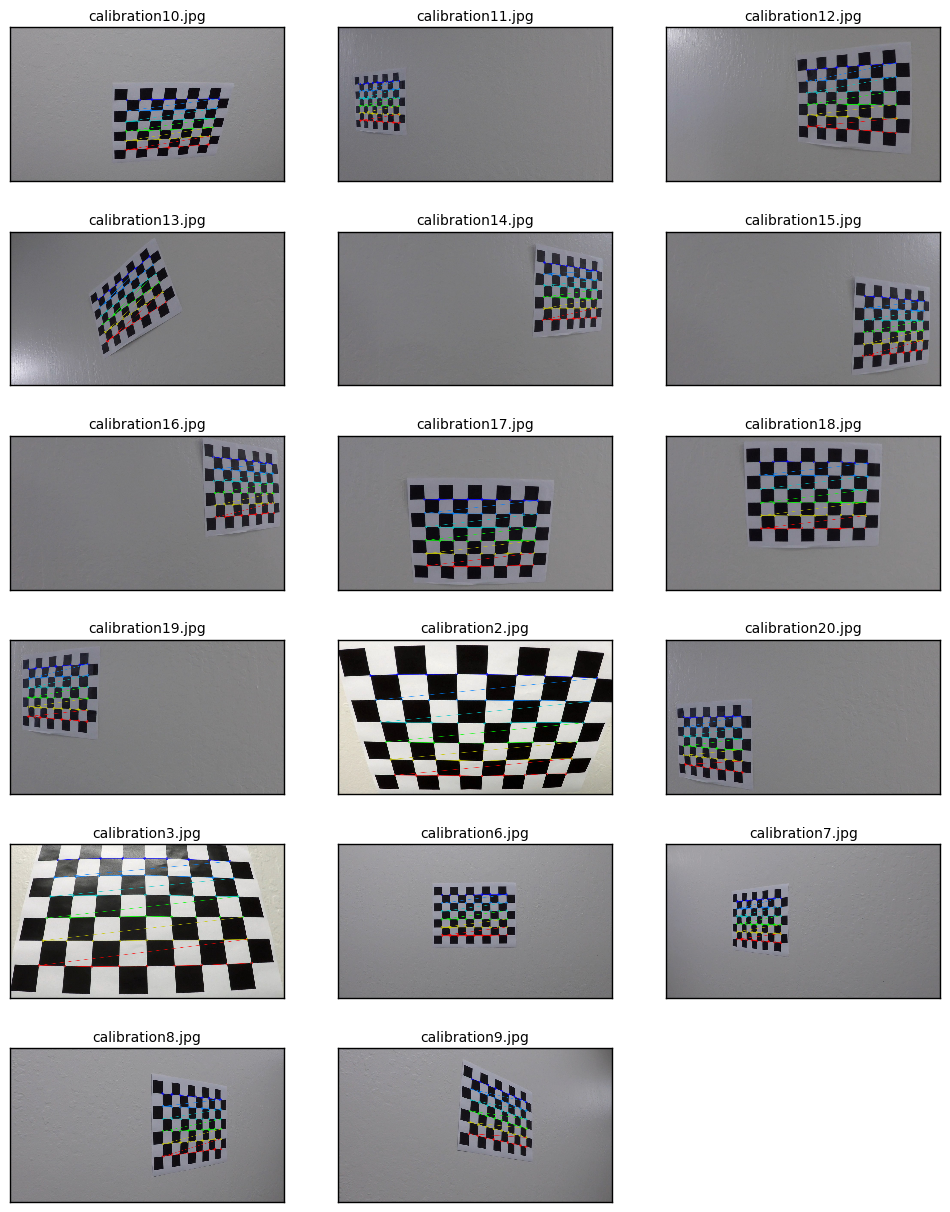

In [53]:
calibr_img_mask = 'calibration*.jpg'
calibr_img_dir = 'camera_cal\\'

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(calibr_img_dir+calibr_img_mask)

#prepair figure to draw on
fig = plt.figure(figsize = (12, 18))  
subplot_coord = 1

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # plot image
        axis = fig.add_subplot(7, 3, subplot_coord, xticks=[], yticks=[])
        subplot_coord += 1
        axis.set_title(os.path.basename(fname), fontsize=10)
        axis.imshow(img)


## Display test images

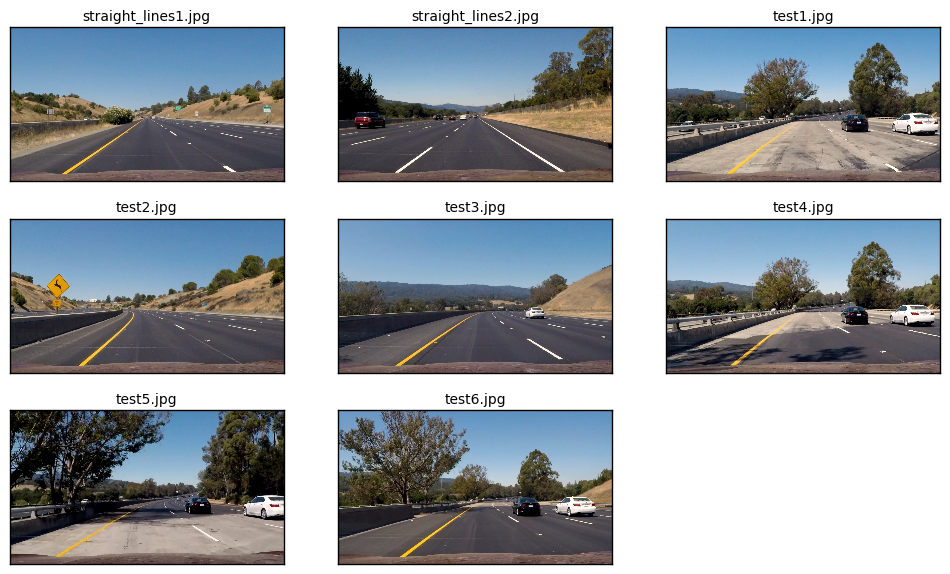

In [36]:
test_img_dir = "test_images/"
images =  os.listdir(test_img_dir) #['00122_Orig.jpg']
fig = plt.figure(figsize = (12, 7))  
subplot_coord = 331
for fname in images:
    image = mpimg.imread(test_img_dir+fname)
    imshape = image.shape

    axis = fig.add_subplot(subplot_coord, xticks=[], yticks=[])
    subplot_coord += 1
    axis.set_title(fname, fontsize=10)
    #img = cv2.cvtColor( img , cv2.COLOR_BGR2RGB)
    axis.imshow(image)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


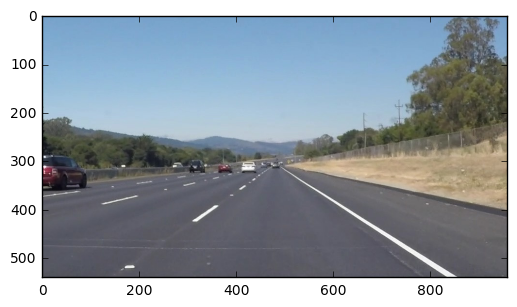

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lane_line(img, y_top, y_bot, a, b, color, thickness):
    top_x = int((y_top - b) / a)
    bot_x = int((y_bot - b) / a)
    cv2.line(img, (top_x, y_top), (bot_x, y_bot), color, thickness)    

def holt_alg(h, y_last, y_pred, T_pred, alpha, beta):
    pred_y_new = alpha * y_last + (1-alpha) * (y_pred + T_pred * h)
    pred_T_new = beta * (pred_y_new - y_pred)/h + (1-beta)*T_pred
    return (pred_y_new, pred_T_new)

def smoothing(t, y, alpha, beta):
    # initialization using the first two observations
    pred_y = y[1]
    pred_T = (y[1] - y[0])/(t[1]-t[0])
    y_hat = [y[0], y[1]]

    for i in range(2, len(t)):
        h = t[i] - t[i-1]
        pred_y, pred_T = holt_alg(h, y[i-1], pred_y, pred_T, alpha, beta)
        y_hat.append(pred_y)
    return pred_y

def history_add(slope_l, slope_r, y_intercept_l, y_intercept_r):
    global avrg_count
    global slope_arr
    global total_frames

    total_frames += 1
    slope_arr.append(np.array([slope_l, y_intercept_l, slope_r, y_intercept_r, total_frames]))
    if len(slope_arr) > avrg_count:
        slope_arr.pop(0)
        
def history_predict():
    global avrg_count
    global slope_arr
    
    alpha=0.8
    beta=0.5
    
    if len(slope_arr) < avrg_count:
        return(.0, .0, 0, 0)
    data = np.array(slope_arr)
    #print(data)
    slope_l = smoothing(data[:,4], data[:,0], alpha, beta)
    b_l = smoothing(data[:,4], data[:,1], alpha, beta)
    slope_r = smoothing(data[:,4], data[:,2], alpha, beta)
    b_r = smoothing(data[:,4], data[:,3], alpha, beta)
    return(slope_l, slope_r, b_l, b_r)
        
def draw_lines(img, lines, verts = None, color=[255, 0, 0], thickness=8):
    global do_prediction
    
    actual_vs_predict_diff = 0.15
    
    debug_mode = False
    img_shape = img.shape
    image_x_middle = int(img_shape[1]/2)
    y_top = verts[0,1,1]
    y_bot = img_shape[0] #verts[0,0,1]
    
    predict_weight = int((y_bot - y_top) * 0.5)
    
    slope_r_arr = []
    slope_l_arr = []
    r_y_incept_arr = []
    l_y_incept_arr = []
    weigh_r_arr = []
    weigh_l_arr = []
    
    #classifying lines 
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            y_intercept = y1-slope*x1
            #so line function is y = x * slope + y_intercept
            if 0.5 < abs(slope) < 0.9: #ignore slopes that are too off
                if slope > 0 and x1 > image_x_middle and x2 > image_x_middle:
                    #right line
                    slope_r_arr.append(slope)
                    weigh_r_arr.append(math.sqrt((y2-y1)**2 + (x2-x1)**2))
                    r_y_incept_arr.append(y_intercept)
                    if debug_mode:
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 2)
                elif x1 < image_x_middle and x2 < image_x_middle:
                    #left line
                    slope_l_arr.append(slope)
                    weigh_l_arr.append(math.sqrt((y2-y1)**2 + (x2-x1)**2))
                    l_y_incept_arr.append(y_intercept)
                    if debug_mode:
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 2)
                else:
                    if debug_mode:
                        cv2.line(img, (x1, y1), (x2, y2), [0,100,0], 2)
            else:
                if debug_mode:
                    cv2.line(img, (x1, y1), (x2, y2), [0,100,0], 2) 
                    
    #predicting position based on previous results
    l_slope_predict = .0 
    r_slope_predict = .0
    l_y_incept_predict = 0 
    r_y_incept_predict = 0  
    if do_prediction:
        l_slope_predict, r_slope_predict, l_y_incept_predict, r_y_incept_predict = history_predict()
        #print(l_slope_predict, r_slope_predict, l_y_incept_predict, r_y_incept_predict)
        if l_slope_predict != .0 and r_slope_predict != .0:
            #appending prediction to current results
            weigh_l_arr.append(predict_weight)
            weigh_r_arr.append(predict_weight)
            slope_l_arr.append(l_slope_predict)
            slope_r_arr.append(r_slope_predict)
            l_y_incept_arr.append(l_y_incept_predict)
            r_y_incept_arr.append(r_y_incept_predict)
        
    #calculate average of found lines and drawing
    if len(slope_l_arr) != 0:
        l_slope_mean = np.average(slope_l_arr, weights = weigh_l_arr)
        l_y_intercept_mean = int(np.average(l_y_incept_arr, weights = weigh_l_arr))
        
        #check diff from prediction and correct
        if l_slope_predict != .0 and (abs(1 - l_slope_predict/l_slope_mean) > actual_vs_predict_diff or abs(1 - (l_y_incept_predict+img_shape[0])/(l_y_intercept_mean+img_shape[0])) > actual_vs_predict_diff):
            l_slope_mean = l_slope_predict
            l_y_intercept_mean = l_y_incept_predict

        draw_lane_line(img, y_top, y_bot, l_slope_mean, l_y_intercept_mean, color, thickness)
            
    if len(slope_r_arr) != 0:
        r_slope_mean = np.average(slope_r_arr, weights = weigh_r_arr)
        r_y_intercept_mean = int(np.average(r_y_incept_arr, weights = weigh_r_arr))
        
        #check diff from prediction and correct
        if r_slope_predict != .0 and (abs(1 - r_slope_predict/r_slope_mean) > actual_vs_predict_diff or abs(1 - (r_y_incept_predict+img_shape[0])/(r_y_intercept_mean+img_shape[0])) > actual_vs_predict_diff):
            r_slope_mean = r_slope_predict
            r_y_intercept_mean = r_y_incept_predict

        draw_lane_line(img, y_top, y_bot, r_slope_mean, r_y_intercept_mean, color, thickness)


    if do_prediction:
        history_add(l_slope_mean, r_slope_mean, l_y_intercept_mean, r_y_intercept_mean)
    
    if debug_mode and verts is not None:
        prev = None
        for vert in verts[0]:
            if prev is not None:
                cv2.line(img, tuple(prev), tuple(vert), [0,0,255], 2)
            prev = vert    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, verts = None):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, verts = verts)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

test_images/solidWhiteCurve.jpg
<class 'numpy.ndarray'>  shape: (540, 960, 3)
test_images/solidWhiteRight.jpg
<class 'numpy.ndarray'>  shape: (540, 960, 3)
test_images/solidYellowCurve.jpg
<class 'numpy.ndarray'>  shape: (540, 960, 3)
test_images/solidYellowCurve2.jpg
<class 'numpy.ndarray'>  shape: (540, 960, 3)
test_images/solidYellowLeft.jpg
<class 'numpy.ndarray'>  shape: (540, 960, 3)
test_images/whiteCarLaneSwitch.jpg
<class 'numpy.ndarray'>  shape: (540, 960, 3)


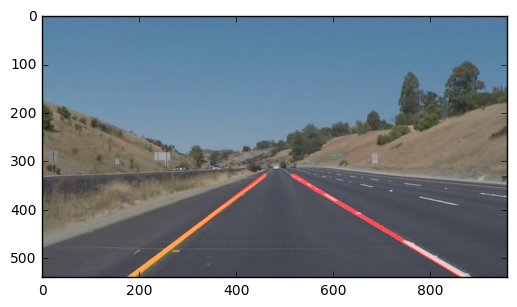

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
do_prediction = False
'''
avrg_count = 8
slope_arr = []
b_arr = []
ts_arr = np.indices((2,avrg_count))[1] # array of two arrays 0..avrg_count
tb_arr = np.indices((2,avrg_count))[1]
total_frames = 0'''

dir_name = "test_images/"#'1/'
image_file_names_array =  os.listdir(dir_name) #['00122_Orig.jpg']
for img_name in image_file_names_array:
    image = mpimg.imread(dir_name+img_name)
    imshape = image.shape
    print(dir_name+img_name)
    print(type(image), ' shape:', imshape)
    
    # find edges
    img_gray_blur = gaussian_blur(grayscale(image), 3)
    
    img_edge = canny(img_gray_blur, low_threshold = 50, high_threshold = 130)
    
    #prepare region mask
    y_top = imshape[0]/2 + imshape[0]/9
    x_cntr_offset = imshape[1]/19
    y_bot_offset = imshape[0]/13
    vertices = np.array([[(0+y_bot_offset, imshape[0]-y_bot_offset), \
                          (imshape[1]/2 - x_cntr_offset, y_top), \
                          (imshape[1]/2 + x_cntr_offset, y_top), \
                          (imshape[1]-y_bot_offset,imshape[0]-y_bot_offset)]], \
                        dtype=np.int32)
    #print(vertices)
    img_edge_masked = region_of_interest(img_edge, vertices)

    # hough transform
    for i in range(16):
        img_hough = hough_lines(img_edge_masked, rho = 2, theta = np.pi/180, threshold = 15, min_line_len = 30, max_line_gap = 15, verts = vertices)
    
    # results
    img_result = weighted_img(img_hough, image)
    cv2.imwrite(dir_name+'Copy_'+img_name, cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    #plt.imshow(img_edge_masked, cmap='gray')
    plt.imshow(img_result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
avrg_count = 8
slope_arr = []
do_prediction = True
total_frames = 0

def reset_global_vars():
    global slope_arr
    global total_frames
    
    slope_arr = []
    total_frames = 0

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global total_frames
    #cv2.imwrite('1/' + str(total_frames+1).zfill(5) + '_Orig.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imshape = image.shape
    img_gray_blur = gaussian_blur(grayscale(image), 3)
    img_edge = canny(img_gray_blur, low_threshold = 50, high_threshold = 150)
    
    #prepare region mask
    y_top = imshape[0]/2 + imshape[0]/9
    x_cntr_offset = imshape[1]/19
    y_bot_offset = imshape[0]/13
    vertices = np.array([[(0+y_bot_offset, imshape[0]-y_bot_offset), \
                          (imshape[1]/2 - x_cntr_offset, y_top), \
                          (imshape[1]/2 + x_cntr_offset, y_top), \
                          (imshape[1]-y_bot_offset,imshape[0]-y_bot_offset)]], \
                        dtype=np.int32)
    img_edge_masked = region_of_interest(img_edge, vertices)
    
    # hough transform
    img_hough = hough_lines(img_edge_masked, rho = 2, theta = np.pi/180, threshold = 15, min_line_len = 30, max_line_gap = 15, verts = vertices)
    # results
    result = weighted_img(img_hough, image)
    #cv2.imwrite('1/' + str(total_frames).zfill(5) + '_Res.jpg', cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
reset_global_vars()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:03<00:00, 67.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 3.67 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
reset_global_vars()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:09<00:00, 74.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 9.68 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

Implemetation enhancements over simple approach I made:
1. Weighted lines based on length.
2. Added prediction to help with jitter on difficult sections

Current implementation limitations:
1. Doesn't expect cars(other objects) in the detection area
2. Doesn't differentiate between line types
3. Doesn't support lane change
4. Good weather and lighting conditions expected
5. Can fail to detect lanes in difficult conditions like shadows, difference in road quality, marks on road or not very pronounced lines themselves
6. Not very good while turning
7. Not fail safe in general

Enhancments that could make detection better:
1. Enhance smoothing between frames
2. Narrow detection area based on predicted line position
3. Improve line detection by looking for rectangles
4. Use not lines but curves 
5. Consider other car sensort like gyroscope and steering to predict car movement in relation to lanes
6. Detect adjasent lines and road boundaries

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
reset_global_vars()
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:21<00:00, 11.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 22.8 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))